# Bike Sharing Demand Prediction - Complete Pipeline

Notebook ini menggabungkan seluruh pipeline dari EDA, preprocessing, training, hingga evaluasi model LSTM untuk prediksi bike sharing demand.

## Struktur Pipeline:
1. **EDA & Data Exploration** - Analisis data historis
2. **Preprocessing** - Feature engineering dan scaling
3. **Model Training** - Pelatihan model LSTM
4. **Model Evaluation** - Evaluasi dan visualisasi hasil
5. **Model Deployment** - Persiapan untuk web app

Semua model dan hasil akan disimpan dalam folder `models/` dan `results/` secara otomatis.


## 1. Import Libraries dan Setup


In [1]:
# Import semua library yang diperlukan
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
import warnings
from datetime import datetime, timedelta

# Machine Learning libraries
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Deep Learning libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# Suppress warnings
warnings.filterwarnings('ignore')

# Set style untuk plotting
plt.style.use('default')
sns.set_palette("husl")

print("✅ Semua library berhasil diimport!")


✅ Semua library berhasil diimport!


## 2. Setup Directories dan Konfigurasi


In [2]:
def create_directories():
    """Buat direktori yang diperlukan"""
    directories = ['models', 'results', 'static', 'templates']
    
    for directory in directories:
        if not os.path.exists(directory):
            os.makedirs(directory)
            print(f"📁 Created directory: {directory}")
        else:
            print(f"📁 Directory exists: {directory}")

def check_data_files():
    """Cek apakah file data ada"""
    required_files = ['../train.csv', '../test.csv']
    missing_files = []
    
    for file in required_files:
        if not os.path.exists(file):
            missing_files.append(file)
        else:
            print(f"✅ Found: {file}")
    
    if missing_files:
        print(f"❌ Missing files: {missing_files}")
        return False
    
    return True

# Setup
print("🔧 Setting up directories and checking files...")
create_directories()
print("\n📊 Checking data files...")
data_ready = check_data_files()

if not data_ready:
    print("\n❌ Please ensure train.csv and test.csv are in the parent directory")
else:
    print("\n✅ Setup complete! Ready to proceed.")


🔧 Setting up directories and checking files...
📁 Directory exists: models
📁 Directory exists: results
📁 Directory exists: static
📁 Directory exists: templates

📊 Checking data files...
✅ Found: ../train.csv
✅ Found: ../test.csv

✅ Setup complete! Ready to proceed.


## 3. EDA & Data Exploration


In [3]:
def load_and_explore_data():
    """Load dan eksplorasi dataset"""
    print("📊 LOADING DATA")
    
    # Load datasets
    train_df = pd.read_csv('../train.csv')
    test_df = pd.read_csv('../test.csv')
    
    print(f"Train dataset shape: {train_df.shape}")
    print(f"Test dataset shape: {test_df.shape}")
    
    # Basic info
    print("\n📋 Train dataset info:")
    print(train_df.info())
    
    print("\n🔍 Missing values:")
    print("Train:", train_df.isnull().sum().sum())
    print("Test:", test_df.isnull().sum().sum())
    
    print("\n📈 Basic statistics:")
    print(train_df.describe())
    
    return train_df, test_df

# Load data
train_df, test_df = load_and_explore_data()


📊 LOADING DATA
Train dataset shape: (10886, 12)
Test dataset shape: (6493, 9)

📋 Train dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB
None

🔍 Missing values:
Train: 0
Test: 0

📈 Basic statistics:
             season       holiday    workingday       weather         temp  \
count  1088

📊 CREATING VISUALIZATIONS


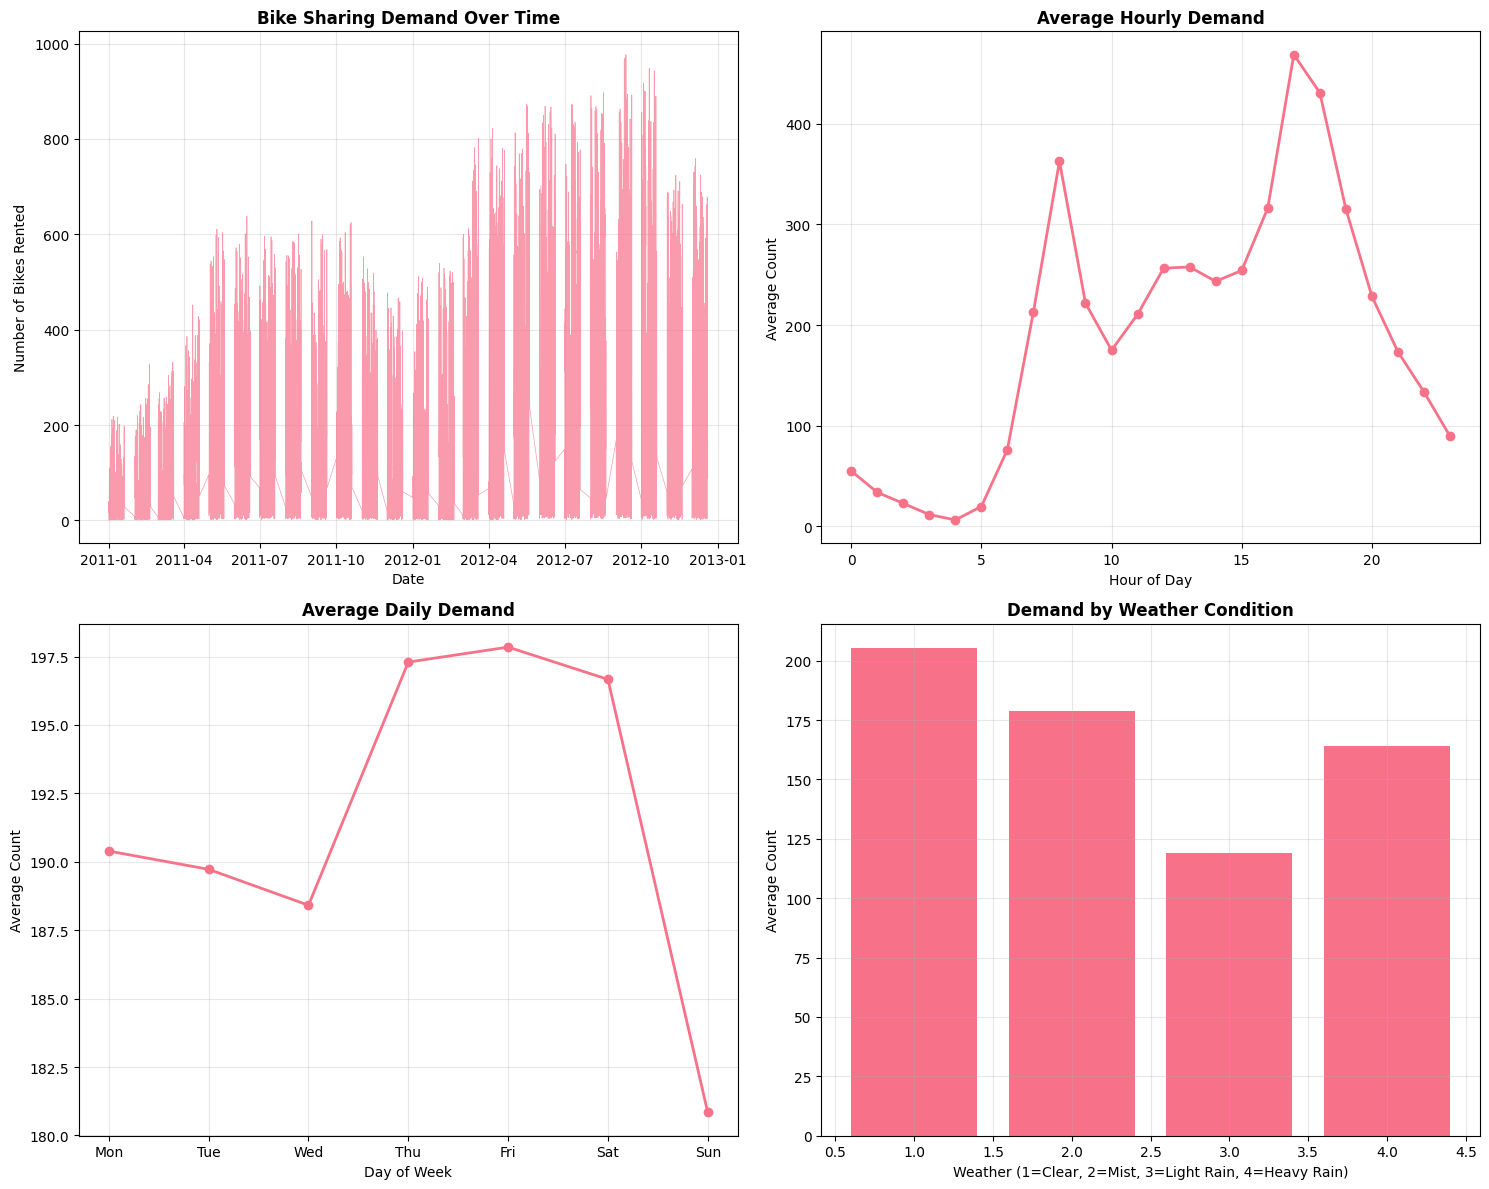

In [4]:
def visualize_data(train_df):
    """Buat visualisasi untuk eksplorasi data"""
    print("📊 CREATING VISUALIZATIONS")
    
    # Convert datetime
    train_df['datetime'] = pd.to_datetime(train_df['datetime'])
    train_df.set_index('datetime', inplace=True)
    
    # Create plots
    plt.figure(figsize=(15, 12))
    
    # Time series plot
    plt.subplot(2, 2, 1)
    plt.plot(train_df.index, train_df['count'], linewidth=0.5, alpha=0.7)
    plt.title('Bike Sharing Demand Over Time', fontweight='bold')
    plt.xlabel('Date')
    plt.ylabel('Number of Bikes Rented')
    plt.grid(True, alpha=0.3)
    
    # Hourly pattern
    plt.subplot(2, 2, 2)
    hourly_pattern = train_df.groupby(train_df.index.hour)['count'].mean()
    plt.plot(hourly_pattern.index, hourly_pattern.values, marker='o', linewidth=2)
    plt.title('Average Hourly Demand', fontweight='bold')
    plt.xlabel('Hour of Day')
    plt.ylabel('Average Count')
    plt.grid(True, alpha=0.3)
    
    # Weekly pattern
    plt.subplot(2, 2, 3)
    weekly_pattern = train_df.groupby(train_df.index.dayofweek)['count'].mean()
    days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
    plt.plot(days, weekly_pattern.values, marker='o', linewidth=2)
    plt.title('Average Daily Demand', fontweight='bold')
    plt.xlabel('Day of Week')
    plt.ylabel('Average Count')
    plt.grid(True, alpha=0.3)
    
    # Weather impact
    plt.subplot(2, 2, 4)
    weather_pattern = train_df.groupby('weather')['count'].mean()
    plt.bar(weather_pattern.index, weather_pattern.values)
    plt.title('Demand by Weather Condition', fontweight='bold')
    plt.xlabel('Weather (1=Clear, 2=Mist, 3=Light Rain, 4=Heavy Rain)')
    plt.ylabel('Average Count')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('results/data_exploration.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return train_df

# Visualize data
train_df = visualize_data(train_df)


## 4. Feature Engineering & Preprocessing


In [5]:
def create_time_features(df):
    """Buat fitur waktu tambahan"""
    df_copy = df.copy()
    
    # Convert datetime column to datetime if it exists
    if 'datetime' in df_copy.columns:
        df_copy['datetime'] = pd.to_datetime(df_copy['datetime'])
        datetime_series = df_copy['datetime']
    else:
        # If datetime is already the index
        datetime_series = df_copy.index
    
    # Extract time components
    if hasattr(datetime_series, 'dt'):
        # It's a Series
        df_copy['hour'] = datetime_series.dt.hour
        df_copy['dayofweek'] = datetime_series.dt.dayofweek
        df_copy['month'] = datetime_series.dt.month
        df_copy['dayofyear'] = datetime_series.dt.dayofyear
    else:
        # It's a DatetimeIndex
        df_copy['hour'] = datetime_series.hour
        df_copy['dayofweek'] = datetime_series.dayofweek
        df_copy['month'] = datetime_series.month
        df_copy['dayofyear'] = datetime_series.dayofyear
    
    # Create weekend flag
    df_copy['is_weekend'] = (df_copy['dayofweek'] >= 5).astype(int)
    
    # Create rush hour flags
    df_copy['is_rush_hour'] = ((df_copy['hour'] >= 7) & (df_copy['hour'] <= 9) | 
                              (df_copy['hour'] >= 17) & (df_copy['hour'] <= 19)).astype(int)
    
    # Create peak hour flag
    df_copy['is_peak_hour'] = ((df_copy['hour'] >= 8) & (df_copy['hour'] <= 10) | 
                              (df_copy['hour'] >= 18) & (df_copy['hour'] <= 20)).astype(int)
    
    return df_copy

def preprocess_data(train_df, test_df):
    """Preprocess data untuk training LSTM"""
    print("🔧 PREPROCESSING DATA")
    
    # Apply feature engineering
    train_df = create_time_features(train_df)
    test_df = create_time_features(test_df)
    
    # Define features to scale
    features_to_scale = ['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp', 
                        'humidity', 'windspeed', 'hour', 'dayofweek', 'month', 'dayofyear',
                        'is_weekend', 'is_rush_hour', 'is_peak_hour']
    
    print(f"Features to scale: {len(features_to_scale)}")
    print(f"Features: {features_to_scale}")
    
    # Initialize scalers
    feature_scaler = MinMaxScaler()
    target_scaler = MinMaxScaler()
    
    # Fit scalers on training data
    train_features_scaled = feature_scaler.fit_transform(train_df[features_to_scale])
    train_target_scaled = target_scaler.fit_transform(train_df[['count']])
    
    # Transform test data
    test_features_scaled = feature_scaler.transform(test_df[features_to_scale])
    
    print(f"Scaled features shape: {train_features_scaled.shape}")
    print(f"Scaled target shape: {train_target_scaled.shape}")
    
    # Save scalers
    joblib.dump(feature_scaler, 'models/feature_scaler.pkl')
    joblib.dump(target_scaler, 'models/target_scaler.pkl')
    
    return train_features_scaled, train_target_scaled, test_features_scaled, features_to_scale

# Preprocess data
train_features_scaled, train_target_scaled, test_features_scaled, features_to_scale = preprocess_data(train_df, test_df)


🔧 PREPROCESSING DATA
Features to scale: 15
Features: ['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp', 'humidity', 'windspeed', 'hour', 'dayofweek', 'month', 'dayofyear', 'is_weekend', 'is_rush_hour', 'is_peak_hour']
Scaled features shape: (10886, 15)
Scaled target shape: (10886, 1)


In [6]:
def create_sequences(data, target, sequence_length=24):
    """Buat sequences untuk training LSTM"""
    X, y = [], []
    
    for i in range(sequence_length, len(data)):
        X.append(data[i-sequence_length:i])
        y.append(target[i])
    
    return np.array(X), np.array(y)

def prepare_lstm_data(train_features_scaled, train_target_scaled, test_features_scaled):
    """Persiapkan data untuk training LSTM"""
    print("🔄 PREPARING LSTM DATA")
    
    # Create sequences
    sequence_length = 24  # Use 24 hours to predict next hour
    X_train, y_train = create_sequences(train_features_scaled, train_target_scaled, sequence_length)
    
    print(f"Training sequences shape: {X_train.shape}")
    print(f"Training targets shape: {y_train.shape}")
    
    # Split data for validation
    split_index = int(0.8 * len(X_train))
    
    X_train_split = X_train[:split_index]
    y_train_split = y_train[:split_index]
    X_val_split = X_train[split_index:]
    y_val_split = y_train[split_index:]
    
    print(f"Training set: {X_train_split.shape}")
    print(f"Validation set: {X_val_split.shape}")
    
    # Save processed data
    np.save('models/X_train.npy', X_train_split)
    np.save('models/y_train.npy', y_train_split)
    np.save('models/X_val.npy', X_val_split)
    np.save('models/y_val.npy', y_val_split)
    np.save('models/test_features_scaled.npy', test_features_scaled)
    
    return X_train_split, y_train_split, X_val_split, y_val_split, sequence_length

# Prepare LSTM data
X_train, y_train, X_val, y_val, sequence_length = prepare_lstm_data(
    train_features_scaled, train_target_scaled, test_features_scaled
)

# Save feature names
np.save('models/feature_names.npy', features_to_scale)

print("\n✅ Data preprocessing complete!")
print(f"Features used: {len(features_to_scale)}")
print(f"Sequence length: {sequence_length}")
print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")


🔄 PREPARING LSTM DATA
Training sequences shape: (10862, 24, 15)
Training targets shape: (10862, 1)
Training set: (8689, 24, 15)
Validation set: (2173, 24, 15)

✅ Data preprocessing complete!
Features used: 15
Sequence length: 24
Training samples: 8689
Validation samples: 2173


## 5. LSTM Model Training


In [7]:
def build_lstm_model(input_shape):
    """Buat arsitektur model LSTM"""
    print("🏗️ BUILDING LSTM MODEL")
    
    model = Sequential([
        # First LSTM layer
        LSTM(128, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        
        # Second LSTM layer
        LSTM(64, return_sequences=False),
        Dropout(0.2),
        
        # Dense layers
        Dense(32, activation='relu'),
        Dropout(0.1),
        Dense(16, activation='relu'),
        
        # Output layer
        Dense(1, activation='linear')
    ])
    
    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae']
    )
    
    print("Model architecture:")
    model.summary()
    
    return model

# Build model
input_shape = (X_train.shape[1], X_train.shape[2])
model = build_lstm_model(input_shape)


🏗️ BUILDING LSTM MODEL
Model architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 24, 128)        │        73,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 125,761 (491.25 KB)

 Trainable params: 125,761 (491.25 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
def train_model(model, X_train, y_train, X_val, y_val):
    """Train model LSTM"""
    print("🚀 TRAINING MODEL")
    
    # Define callbacks
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    )
    
    model_checkpoint = ModelCheckpoint(
        'models/lstm_model.h5',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
    
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=0.0001,
        verbose=1
    )
    
    # Train model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=50,
        batch_size=32,
        callbacks=[early_stopping, model_checkpoint, reduce_lr],
        verbose=1
    )
    
    return history

# Train model
history = train_model(model, X_train, y_train, X_val, y_val)


🚀 TRAINING MODEL
Epoch 1/50
271/272 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0223 - mae: 0.1091
Epoch 1: val_loss improved from None to 0.02678, saving model to models/lstm_model.h5


272/272 ━━━━━━━━━━━━━━━━━━━━ 28s 70ms/step - loss: 0.0170 - mae: 0.0923 - val_loss: 0.0268 - val_mae: 0.1106 - learning_rate: 0.0010
Epoch 2/50
271/272 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0095 - mae: 0.0677
Epoch 2: val_loss improved from 0.02678 to 0.02389, saving model to models/lstm_model.h5


272/272 ━━━━━━━━━━━━━━━━━━━━ 20s 69ms/step - loss: 0.0090 - mae: 0.0655 - val_loss: 0.0239 - val_mae: 0.1097 - learning_rate: 0.0010
Epoch 3/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0080 - mae: 0.0619
Epoch 3: val_loss improved from 0.02389 to 0.02161, saving model to models/lstm_model.h5


272/272 ━━━━━━━━━━━━━━━━━━━━ 17s 63ms/step - loss: 0.0076 - mae: 0.0597 - val_loss: 0.0216 - val_mae: 0.1075 - learning_rate: 0.0010
Epoch 4/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0073 - mae: 0.0576
Epoch 4: val_loss did not improve from 0.02161
272/272 ━━━━━━━━━━━━━━━━━━━━ 22s 65ms/step - loss: 0.0069 - mae: 0.0569 - val_loss: 0.0222 - val_mae: 0.1062 - learning_rate: 0.0010
Epoch 5/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0063 - mae: 0.0543
Epoch 5: val_loss improved from 0.02161 to 0.02149, saving model to models/lstm_model.h5


272/272 ━━━━━━━━━━━━━━━━━━━━ 14s 52ms/step - loss: 0.0067 - mae: 0.0559 - val_loss: 0.0215 - val_mae: 0.1090 - learning_rate: 0.0010
Epoch 6/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0064 - mae: 0.0546
Epoch 6: val_loss improved from 0.02149 to 0.01988, saving model to models/lstm_model.h5


272/272 ━━━━━━━━━━━━━━━━━━━━ 13s 49ms/step - loss: 0.0061 - mae: 0.0533 - val_loss: 0.0199 - val_mae: 0.1029 - learning_rate: 0.0010
Epoch 7/50
271/272 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0060 - mae: 0.0530
Epoch 7: val_loss improved from 0.01988 to 0.01861, saving model to models/lstm_model.h5


272/272 ━━━━━━━━━━━━━━━━━━━━ 14s 50ms/step - loss: 0.0061 - mae: 0.0535 - val_loss: 0.0186 - val_mae: 0.0989 - learning_rate: 0.0010
Epoch 8/50
271/272 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0057 - mae: 0.0520
Epoch 8: val_loss did not improve from 0.01861
272/272 ━━━━━━━━━━━━━━━━━━━━ 14s 52ms/step - loss: 0.0056 - mae: 0.0511 - val_loss: 0.0252 - val_mae: 0.1142 - learning_rate: 0.0010
Epoch 9/50
271/272 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0056 - mae: 0.0515
Epoch 9: val_loss improved from 0.01861 to 0.01578, saving model to models/lstm_model.h5


272/272 ━━━━━━━━━━━━━━━━━━━━ 21s 52ms/step - loss: 0.0056 - mae: 0.0513 - val_loss: 0.0158 - val_mae: 0.0927 - learning_rate: 0.0010
Epoch 10/50
271/272 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0055 - mae: 0.0506
Epoch 10: val_loss did not improve from 0.01578
272/272 ━━━━━━━━━━━━━━━━━━━━ 13s 47ms/step - loss: 0.0054 - mae: 0.0504 - val_loss: 0.0202 - val_mae: 0.1040 - learning_rate: 0.0010
Epoch 11/50
271/272 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0049 - mae: 0.0482
Epoch 11: val_loss did not improve from 0.01578
272/272 ━━━━━━━━━━━━━━━━━━━━ 14s 50ms/step - loss: 0.0050 - mae: 0.0483 - val_loss: 0.0177 - val_mae: 0.0961 - learning_rate: 0.0010
Epoch 12/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0048 - mae: 0.0472
Epoch 12: val_loss did not improve from 0.01578

Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
272/272 ━━━━━━━━━━━━━━━━━━━━ 13s 48ms/step - loss: 0.0051 - mae: 0.0487 - val_loss: 0.0238 - val_mae: 0.1095 - learning_rate: 0.00

## 6. Model Evaluation & Summary


In [9]:
def evaluate_model(model, X_val, y_val, target_scaler):
    """Evaluasi kinerja model"""
    print("📊 EVALUATING MODEL")
    
    # Make predictions
    y_pred = model.predict(X_val)
    
    # Inverse transform untuk mendapatkan nilai asli
    y_val_original = target_scaler.inverse_transform(y_val.reshape(-1, 1)).flatten()
    y_pred_original = target_scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
    
    # Calculate metrics
    mse = np.mean((y_val_original - y_pred_original) ** 2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(y_val_original - y_pred_original))
    mape = np.mean(np.abs((y_val_original - y_pred_original) / y_val_original)) * 100
    
    print(f"Validation RMSE: {rmse:.2f}")
    print(f"Validation MAE: {mae:.2f}")
    print(f"Validation MAPE: {mape:.2f}%")
    
    return y_pred_original, y_val_original, rmse, mae, mape

# Load target scaler
target_scaler = joblib.load('models/target_scaler.pkl')

# Evaluate model
y_pred_original, y_val_original, rmse, mae, mape = evaluate_model(model, X_val, y_val, target_scaler)


📊 EVALUATING MODEL
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step
Validation RMSE: 122.62
Validation MAE: 90.43
Validation MAPE: 82.10%


In [10]:
def save_model_summary(rmse, mae, mape, features_to_scale, sequence_length):
    """Simpan ringkasan model"""
    print("💾 SAVING MODEL SUMMARY")
    
    # Save metrics
    metrics = {
        'rmse': float(rmse),
        'mae': float(mae),
        'mape': float(mape),
        'sequence_length': sequence_length,
        'features': len(features_to_scale)
    }
    
    joblib.dump(metrics, 'models/model_metrics.pkl')
    
    # Save summary as text
    with open('results/model_summary.txt', 'w') as f:
        f.write("=== MODEL TRAINING SUMMARY ===\n")
        f.write(f"Model: LSTM\n")
        f.write(f"RMSE: {rmse:.2f}\n")
        f.write(f"MAE: {mae:.2f}\n")
        f.write(f"MAPE: {mape:.2f}%\n")
        f.write(f"Sequence Length: {sequence_length} hours\n")
        f.write(f"Number of Features: {len(features_to_scale)}\n")
        f.write(f"Features: {', '.join(features_to_scale)}\n")
        f.write("\nModel is ready for deployment!\n")
    
    print("\n=== TRAINING SUMMARY ===")
    print(f"Final RMSE: {rmse:.2f}")
    print(f"Final MAE: {mae:.2f}")
    print(f"Final MAPE: {mape:.2f}%")
    print("Model saved to: models/lstm_model.h5")
    print("Metrics saved to: models/model_metrics.pkl")
    print("Summary saved to: results/model_summary.txt")
    print("\n✅ Training complete! Model is ready for web deployment.")

# Save summary
save_model_summary(rmse, mae, mape, features_to_scale, sequence_length)


💾 SAVING MODEL SUMMARY

=== TRAINING SUMMARY ===
Final RMSE: 122.62
Final MAE: 90.43
Final MAPE: 82.10%
Model saved to: models/lstm_model.h5
Metrics saved to: models/model_metrics.pkl
Summary saved to: results/model_summary.txt

✅ Training complete! Model is ready for web deployment.


## 7. Web App Deployment

Model telah berhasil dilatih dan disimpan. Sekarang Anda dapat menjalankan web app dengan cara berikut:


In [11]:
# Cek file yang telah dibuat
print("📁 Files created:")
print("\nModels:")
for file in os.listdir('models'):
    print(f"  - models/{file}")

print("\nResults:")
for file in os.listdir('results'):
    print(f"  - results/{file}")

print("\n🌐 To start the web application:")
print("1. Run: python run_web_app.py")
print("2. Or run: python src/app.py")
print("3. Or double-click: run_web_app.bat")
print("4. Open: http://localhost:5000")
print("\n✅ All done! Your model is ready for deployment.")


📁 Files created:

Models:
  - models/feature_names.npy
  - models/feature_scaler.pkl
  - models/lstm_model.h5
  - models/model_metrics.pkl
  - models/target_scaler.pkl
  - models/test_features_scaled.npy
  - models/X_train.npy
  - models/X_val.npy
  - models/y_train.npy
  - models/y_val.npy

Results:
  - results/data_exploration.png
  - results/model_summary.txt

🌐 To start the web application:
1. Run: python run_web_app.py
2. Or run: python src/app.py
3. Or double-click: run_web_app.bat
4. Open: http://localhost:5000

✅ All done! Your model is ready for deployment.
